In [1]:
import os, glob, sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)    
import balltracking.balltrack as blt
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib import rc
# Load FLCT
from pathlib import Path, PurePath
from IPython.display import display
import time
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# matplotlib.rcParams.update({'font.family': 'Times New Roman'})
%matplotlib inline
# matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
# matplotlib.rcParams.update({'axes.labelsize': 12})
matplotlib.rcParams.update({'font.size': 16})
pd.options.display.max_columns = None

datadir = os.environ['DATA']

In [2]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return np.array([vx, vy])


def smooth_vel(v, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm]) / fwhm**2
        vxs2 = convolve2d(v[0,...], box, mode='same')
        vys2 = convolve2d(v[1,...], box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(v[0,...], sigma=sigma, order=0)
        vys2 = gaussian_filter(v[1,...], sigma=sigma, order=0)
        
    vm = np.sqrt(vxs2**2 + vys2**2)
    return np.array([vxs2, vys2, vm])


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


In [3]:
datadir = Path(os.environ['DATA'], 'Ben', 'SteinSDO')
outputdir = Path(datadir, 'comparisons')

u = 368000 / 60

fwhms = [7,11,15]
kernels = ['boxcar',]
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used trim = 10px for fwhm = 7
trims = [10, 11, 15]
fovs = [np.s_[trim:-trim:fwhm, trim:-trim:fwhm] for trim, fwhm in zip(trims, fwhms)]

tranges = [[60, nt] for nt in range(60+30, 364, 5)]
nframes = [trange[1]-60 for trange in tranges]
nflows = len(tranges)
print("number of time-averaged flow maps: ", nflows)
print(tranges)

number of time-averaged flow maps:  55
[[60, 90], [60, 95], [60, 100], [60, 105], [60, 110], [60, 115], [60, 120], [60, 125], [60, 130], [60, 135], [60, 140], [60, 145], [60, 150], [60, 155], [60, 160], [60, 165], [60, 170], [60, 175], [60, 180], [60, 185], [60, 190], [60, 195], [60, 200], [60, 205], [60, 210], [60, 215], [60, 220], [60, 225], [60, 230], [60, 235], [60, 240], [60, 245], [60, 250], [60, 255], [60, 260], [60, 265], [60, 270], [60, 275], [60, 280], [60, 285], [60, 290], [60, 295], [60, 300], [60, 305], [60, 310], [60, 315], [60, 320], [60, 325], [60, 330], [60, 335], [60, 340], [60, 345], [60, 350], [60, 355], [60, 360]]


### Balltracking data
Look at correlation dataframe created by "optimization/parameter_sweep_velocity_calibration.py", whose source data are computed by "optimization/balltrack_parameter_sweep.py", feasible only in reasonable time with parallel processing (50 cores sollicited takes ~24hr). Here I look at different best metrics to see what are the corresponding balltrack parameters. I run Balltracking with what minimizes the error with the simulation (balltracking_scripts/stein_balltrack.py). At just a difference of the 2d digit with the correlation, I favor the smallest MAE instead of the highest correlation.

In [4]:
caldf = pd.read_csv(Path(os.environ['DATA'],'sanity_check/stein_series/correlation_dataframe2.csv'))

In [5]:
caldf

,rs,intsteps,ballspacing,dp,sigma_factor,fourier_radius,kernel,fwhm,corr_uncal,corr,corr_top,corr_bot,MAE_uncal_vx,MAE_uncal_vy,MAE_cal_vx,MAE_cal_vy,RMSE_uncal_vx,RMSE_uncal_vy,RMSE_cal_vx,RMSE_cal_vy,p_top_0,p_top_1,p_bot_0,p_bot_1,vx_top -0.20,vx_top -0.16,vx_top -0.12,vx_top -0.08,vx_top -0.04,vx_top 0.00,vx_top 0.04,vx_top 0.08,vx_top 0.12,vx_top 0.16,vx_top 0.20,vx_bottom -0.20,vx_bottom -0.16,vx_bottom -0.12,vx_bottom -0.08,vx_bottom -0.04,vx_bottom 0.00,vx_bottom 0.04,vx_bottom 0.08,vx_bottom 0.12,vx_bottom 0.16,vx_bottom 0.20,MAE_cal_vx_top,MAE_cal_vx_bot,RMSE_cal_vx_top,RMSE_cal_vx_bot
0,2,4,1,0.2,1.0,0,boxcar,7,0.808366,0.806909,0.757138,0.719114,377.951108,382.326551,275.241690,265.165648,468.416492,471.897917,347.091543,333.819057,3.744929,0.009645,4.272900,0.007993,-0.056455,-0.045390,-0.034259,-0.023797,-0.013329,-0.002028,0.008257,0.018486,0.029824,0.039282,0.051079,-0.049064,-0.039119,-0.029375,-0.020301,-0.011004,-0.002696,0.007152,0.016596,0.026249,0.035968,0.045016,315.574981,343.719163,393.799857,436.479263
1,2,4,1,0.2,1.0,1,boxcar,7,0.907728,0.906511,0.880399,0.847006,377.912758,383.123963,193.968016,193.145729,469.386891,472.273308,242.586108,237.487271,4.247210,0.011299,5.042408,0.007500,-0.050052,-0.040459,-0.030806,-0.021204,-0.011650,-0.002428,0.006308,0.016086,0.025573,0.034715,0.044652,-0.041457,-0.033033,-0.025186,-0.017306,-0.009284,-0.001181,0.006349,0.014070,0.022075,0.030027,0.038566,213.202255,249.691175,267.294418,313.009722
2,2,4,1,0.2,1.0,2,boxcar,7,0.905036,0.903950,0.876504,0.847226,377.278047,382.523251,193.072163,193.221048,468.350892,471.990952,244.432014,241.659009,4.216116,0.011201,5.001815,0.007120,-0.050228,-0.040856,-0.031195,-0.021312,-0.011625,-0.002537,0.006733,0.016269,0.025160,0.035472,0.044895,-0.041842,-0.033598,-0.025108,-0.017085,-0.009306,-0.001010,0.006397,0.014377,0.022492,0.030550,0.038473,214.849855,248.256462,270.617524,313.980853
3,2,4,1,0.2,1.0,3,boxcar,7,0.896909,0.895958,0.864098,0.836400,377.557004,383.746145,202.428647,200.411088,468.864939,473.233671,253.418755,251.447109,4.173596,0.010328,4.933470,0.007443,-0.051061,-0.040476,-0.031060,-0.021595,-0.011639,-0.002272,0.007156,0.016455,0.025861,0.035780,0.045630,-0.042872,-0.033780,-0.025713,-0.017429,-0.009449,-0.000940,0.006841,0.014362,0.022924,0.030902,0.038560,230.013192,252.159991,289.065700,316.986160
4,2,4,1,0.2,1.0,4,boxcar,7,0.888825,0.887669,0.850929,0.818086,377.448656,382.947790,209.298202,210.901391,468.281617,473.170088,260.107756,263.405620,4.084095,0.010154,4.757087,0.007356,-0.052028,-0.041424,-0.031776,-0.021828,-0.011997,-0.002204,0.006874,0.017064,0.026962,0.036489,0.046521,-0.044014,-0.035528,-0.026007,-0.018321,-0.009566,-0.001392,0.006986,0.014791,0.023360,0.031729,0.040951,243.335892,259.955549,302.940733,329.139278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2,6,2,0.4,2.0,5,boxcar,7,0.917763,0.917648,0.888197,0.895992,255.466848,261.548452,175.107326,184.243622,316.716419,324.140204,221.397364,230.573783,1.815119,0.012451,1.669672,0.008891,-0.116594,-0.094585,-0.073213,-0.051102,-0.030176,-0.007025,0.015366,0.037528,0.060091,0.081361,0.102894,-0.125050,-0.101603,-0.076840,-0.052805,-0.029858,-0.005122,0.019031,0.042414,0.066030,0.090566,0.114666,208.095103,197.739164,260.722711,249.429372
1496,2,6,2,0.4,2.0,6,boxcar,7,0.912940,0.912728,0.874417,0.888304,258.557756,265.897861,181.814148,189.183861,321.233470,329.589156,228.406638,236.108578,1.829943,0.013304,1.693064,0.008714,-0.116675,-0.094468,-0.072594,-0.051207,-0.029824,-0.007346,0.014678,0.037143,0.058981,0.079533,0.101810,-0.123551,-0.099568,-0.075862,-0.052493,-0.028811,-0.004979,0.018444,0.042675,0.065340,0.089356,0.112833,219.620024,205.167013,276.536756,258.447940
1497,2,6,2,0.4,2.0,7,boxcar,7,0.903893,0.903792,0.863502,0.872051,264.062531,272.491287,189.392973,1

In [6]:
cols = ['rs', 'ballspacing', 'intsteps', 'dp', 'sigma_factor', 'fourier_radius', 'corr', 'corr_top', 'corr_bot', 'MAE_cal_vx_top',  'MAE_cal_vx_bot', 'p_top_0', 'p_bot_0']
idx_cols = [caldf.columns.get_loc(c) for idx, c in enumerate(cols)]
caldf.iloc[[
    np.argmax(caldf['corr'].values), 
    np.argmax(caldf['corr_top'].values), 
    np.argmax(caldf['corr_bot'].values), 
    np.argmin(caldf['MAE_cal_vx_top'].values), 
    np.argmin(caldf['MAE_cal_vx_bot'].values),
    np.argmin(caldf['p_top_0'].values), 
    np.argmin(caldf['p_bot_0'].values)], idx_cols]

,rs,ballspacing,intsteps,dp,sigma_factor,fourier_radius,corr,corr_top,corr_bot,MAE_cal_vx_top,MAE_cal_vx_bot,p_top_0,p_bot_0
821,2,2,5,0.25,1.5,1,0.940217,0.918854,0.922877,181.111065,175.737212,1.790232,1.702257
591,2,1,5,0.25,2.0,1,0.935458,0.921862,0.901495,176.349977,200.034601,3.383824,3.933904
341,2,2,4,0.25,2.0,1,0.938875,0.915003,0.926585,187.532458,174.317748,2.082782,1.945851
1141,2,1,6,0.30,2.0,1,0.936104,0.921822,0.907909,175.908786,197.093071,2.990752,3.184239
291,2,2,4,0.20,2.0,1,0.936425,0.911733,0.923385,182.600402,171.933264,2.148097,2.048243
1354,2,2,6,0.30,1.0,4,0.921044,0.891293,0.900953,203.744718,192.013686,1.576148,1.538151
1403,2,2,6,0.35,1.0,3,0.926258,0.898259,0.907348,202.323543,186.622107,1.601125,1.523806


Now first, need to run Balltracking with these optimized parameters in balltracking_scripts/stein_balltrack2.py
- best top-tracking: rs=2, ballspacing =1 intsteps = 6, dp=0.30, sigma_factor=2.0, fourier_radius = 1
- best bottom-tracking: rs=2, ballspacing =2 intsteps = 4 dp=0.20, sigma_factor=2.0,, fourier_radius = 1

### Load Stein simulation data

In [7]:
# Load Stein data
svx_files = sorted(datadir.rglob('SDO_vx*.fits'))
svy_files = sorted(datadir.rglob('SDO_vy*.fits'))
v_stein_l = [load_vel_mean((svx_files, svy_files), trange) for trange in tranges]
# smooth the Stein velocities 
v_stein_sm = [[smooth_vel(v, fwhm, kernel=kernel) for v in v_stein_l] for fwhm in fwhms]
npts_ = [v_stein_sm[f][0][0][fov].size for f, fov in enumerate(fovs)]

### Load Balltracking data from balltracking_scripts/stein_balltrack2.py

In [80]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    fov = fovs[i]
    # Load Balltrack velocities. processed with balltracking_scripts/generic_balltrack.py, calibrated with balltracking/generic_calibration
    # bvxs = [np.load(os.path.join(datadir, 'balltrack/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm, trange[1])))['vx'] for trange in tranges]
    
    # Load Balltrack velocities. processed with balltracking_scripts/stein_balltrack2.py, calibrated with balltracking/stein_calibration2
    bvs = [np.array([np.load(os.path.join(datadir, 'balltrack3/vxy_{:s}_fwhm_{:d}_avg_{:d}.npz'.format(kernel, fwhm_i, trange[1])))[var] for var in ['vx_cal', 'vy_cal']]) for trange in tranges]
    bvsm = [np.sqrt(bvs[j][0][:]**2 + bvs[j][1][:]**2) for j in range(nflows)]
    
    # Fit Balltracking to Stein simulation
    bps, brs, _, _, _ = zip(*[np.polyfit(bvs[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    brs = [np.sqrt(br[0]/npts_[i]) for br in brs]
    print('Balltrack residuals from fit: ', brs[0])
    b_alphas, b_offsets = map(list, zip(*bps))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - bvs[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSEs = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE Balltracking = ',  b_RMSEs[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - bvsm[j][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                               'vx': bvs[j][0][fov].ravel()*u, 'vy': bvs[j][1][fov].ravel()*u, 'vmag':bvsm[j][fov].ravel()*u,
                               'vx_cal': bvs[j][0][fov].ravel()*u,
                               'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 
                               'error':error_field[j], 'error_cal':error_field[j], 
                               'APE': APE_field_masked[j], 'APE_cal': APE_field_masked[j], 'APE_cal_unmasked': APE_field[j],
                               'nframes':nframes[j], 'FWHM':fwhm_i, 'FWHM (Mm)':fwhm_i*0.368, 'kernel':kernel, 'Algorithm':'Balltracking'}) for j in range(nflows)])
    
    bMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    # Correlations between Balltracking and simulation
    bcorrs = [calc_c_pearson(v_stein_sm[i][j][0], bvs[j][0], v_stein_sm[i][j][1], bvs[j][1], fov=fov) for j in range(len(tranges))]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':b_alphas, 'slope_cal':b_alphas, 'RMSE':RMSEs, 'MAPE':bMAPE, 'MAPE_cal':bMAPE, 'correlation':bcorrs, 'FWHM':fwhm_i, 'FWHM (Mm)':fwhm_i*0.368, 'kernel':kernel, 'Algorithm':'Balltracking'})
    
    dfs1.append(df1)
    dfs2.append(df2)

bdf1 = pd.concat(dfs1)
bdf2 = pd.concat(dfs2)
display(bdf1.head())
display(bdf2.head())

Balltrack residuals from fit:  266.6127540060622
Balltrack residuals from fit:  160.73415837003435
Balltrack residuals from fit:  120.46410700254029


,vx_stein,vy_stein,vx,vy,vmag,vx_cal,vmag_stein,error,error_cal,APE,APE_cal,APE_cal_unmasked,nframes,FWHM,FWHM (Mm),kernel,Algorithm
0,525.432311,-948.284186,922.437321,-877.619201,1273.226639,922.437321,1084.122692,397.005010,397.005010,17.443039,17.443039,17.443039,30,7,2.576,boxcar,Balltracking
1,916.049585,-572.826726,1056.802547,-382.397490,1123.859183,1056.802547,1080.406082,140.752961,140.752961,4.021923,4.021923,4.021923,30,7,2.576,boxcar,Balltracking
2,-1007.115762,-1110.103040,-1052.937734,-1163.067804,1568.886417,-1052.937734,1498.869881,45.821972,45.821972,4.671288,4.671288,4.671288,30,7,2.576,boxcar,Balltracking
3,-437.777538,-185.887513,-454.135681,-344.769254,570.179845,-454.135681,475.608390,16.358143,16.358143,19.884312,19.884312,19.884312,30,7,2.576,boxcar,Balltracking
4,-1410.647323,-248.693093,-944.093701,-492.349854,1064.763492,-944.093701,1432.401523,466.553622,466.553622,25.665850,25.665850,25.665850,30,7,2.576,boxcar,Balltracking


,nframes,slope,slope_cal,RMSE,MAPE,MAPE_cal,correlation,FWHM,FWHM (Mm),kernel,Algorithm
0,30,0.969155,0.969155,267.235624,23.960654,23.960654,0.899424,7,2.576,boxcar,Balltracking
1,35,0.980906,0.980906,250.176114,24.046054,24.046054,0.909487,7,2.576,boxcar,Balltracking
2,40,0.988091,0.988091,235.660435,22.194767,22.194767,0.916290,7,2.576,boxcar,Balltracking
3,45,0.998291,0.998291,223.195307,20.890231,20.890231,0.923183,7,2.576,boxcar,Balltracking
4,50,1.003000,1.003000,210.501263,21.358373,21.358373,0.928943,7,2.576,boxcar,Balltracking


# Drift test

### Get FLCT velocities

In [9]:
import re
flct_drift_dirs = sorted(Path(os.environ['DATA'], 'sanity_check/stein_series/output_FLCT_sigma4').rglob('drift_*'))
flct_vxf = [sorted([Path(fdir, f) for f in os.listdir(str(fdir)) if re.search(r'FLCT_vx1_\d{3}.fits', f)])[0:60] for fdir in flct_drift_dirs]

In [10]:
flct_vx_drifts = np.array([np.array([fitsio.read(f) for f in drift_f]).mean() for drift_f in flct_vxf])
m0 = flct_vx_drifts[5]
flct_vx_drifts -= m0

In [11]:
dv = 0.04
vx_rates = np.arange(-0.2, 0.21, dv)

slope: [0.78832928]
intercept: -0.00024489889090713806
correction coefficient:  [1.26850546]


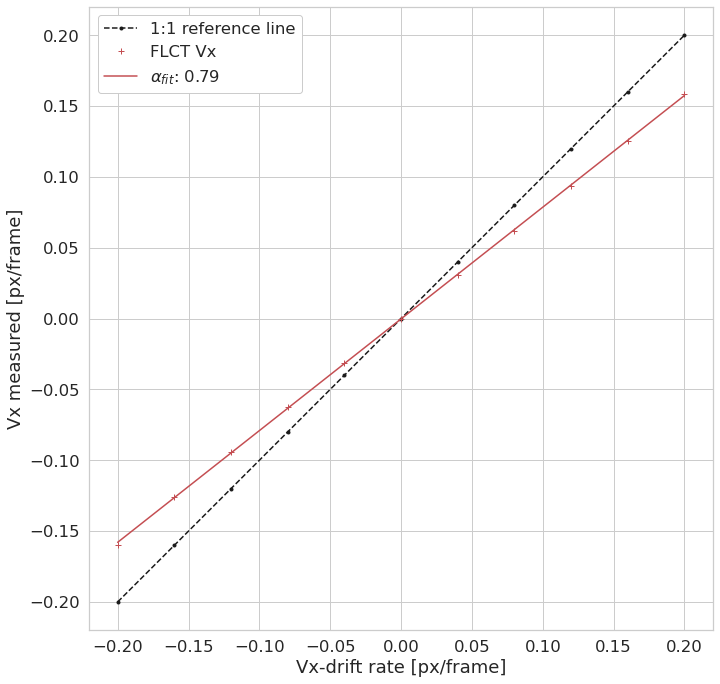

In [95]:
model = LinearRegression().fit(vx_rates.reshape((-1,1)), flct_vx_drifts)
vx_pred = model.predict(vx_rates.reshape((-1,1)))
print('slope:', model.coef_)
print('intercept:', model.intercept_)

plt.figure(figsize=(10,10))
plt.plot(vx_rates, vx_rates, 'k.--', label='1:1 reference line')
plt.plot(vx_rates, flct_vx_drifts, 'r+', label='FLCT Vx')
plt.plot(vx_rates, vx_pred, 'r-', label=rf'$\alpha_{{fit}}$: {model.coef_[0]:.2f}')
plt.gca().set_aspect('equal')
plt.xlabel('Vx-drift rate [px/frame]'), plt.ylabel('Vx measured [px/frame]')
plt.legend()
plt.grid(True)
plt.tight_layout()
a_flct = 1/model.coef_
print('correction coefficient: ', 1/model.coef_)
plt.savefig(Path(outputdir, 'drift_stein_flct_calibration.png'))
plt.savefig(Path(outputdir, 'drift_stein_flct_calibration.jpg'))

Balltracking is already well calibrated as demontrasted in the lmplot above. Showing it here does not add useful information. 

TODO: 
(1) have a look at the alphas from the dataframes computed for FLCT and Balltracking. Those of Balltracking should remain close to 1. Check
    > Balltracking remains close to 1. FLCT is more dispersed and at greater time average it converges to a value different than the one here which is at 30 min. 
(2) prepare a longer series of drifted data for FLCT, in order to look at where the FLCT slope converge over greater time averages and over different time windows. 
(3) apply the scaling correction shown in this last fit to FLCT to the dataframes as used in lmplot. Show the new errors and compare again with Balltracking. 
(4) Show the variability of these errors on other samples. E.g. MAE from another time series?

### FLCT data (non-drifted)

In [16]:
# Load fits files
datadir_flct = Path(os.environ['DATA'], 'Ben/SteinSDO/FLCT_Raphael/output_FLCT_sigma4')
fvx_files = sorted(datadir_flct.rglob('FLCT_vx*.fits'))
fvy_files = sorted(datadir_flct.rglob('FLCT_vy*.fits'))

In [17]:
# Average over time
fvs = [load_vel_mean((fvx_files, fvy_files), trange) for trange in tranges]

In [81]:
dfs1 = []
dfs2 = []

for i, fwhm_i in enumerate(fwhms):
    if fwhm_i == 7:
        print('no smoothing')
        fvs2 = [np.array([fv[0], fv[1], np.sqrt(fv[0][:]**2 + fv[1][:]**2)]) for fv in fvs]
    else:
        # Smooth Stein velocities
        print(f'smoothing at {fwhm_i} px')
        fvs2 = [smooth_vel(fv, fwhm_i, kernel=kernel) for fv in fvs]
    
    fvs2_cal = [fv*a_flct for fv in fvs2]
    fov = fovs[i]
    # Fit FLCT to Stein simulation
    fps, frs, _, _, _ = zip(*[np.polyfit(fvs2[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    frs = [np.sqrt(fr[0]/npts_[i]) for fr in frs]
    print('FLCT residuals w.r to simulation after fit: ', frs[0])
    f_alphas, f_offsets = map(list, zip(*fps))
    # fit on balltrack-like calibration
    fps_cal, frs_cal, _, _, _ = zip(*[np.polyfit(fvs2_cal[j][0][fov].ravel()*u, v_stein_sm[i][j][0][fov].ravel(), 1, full=True) for j in range(nflows)])
    f_alphas_cal, _ = map(list, zip(*fps_cal))
    # Calculate residuals RMSE
    error_field = [np.abs(v_stein_sm[i][j][0][fov] - fvs2[j][0][fov]*u).ravel() for j in range(nflows)]
    error_field_cal = [np.abs(v_stein_sm[i][j][0][fov] - fvs2_cal[j][0][fov]*u).ravel() for j in range(nflows)]
    RMSE_uncal = [np.sqrt(np.mean(error_field[j]**2)) for j in range(nflows)]
    # print('RMSE FLCT (uncalibrated) = ',  fRMSE_uncals[0])
    # Relative error (Mean Absolute Percentage Error: MAPE)
    APE_field_masked = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]
    APE_field_masked_cal = [np.abs((v_stein_sm[i][j][2][fov] - fvs2_cal[j][2][fov]*u)/np.ma.masked_less_equal(v_stein_sm[i][j][2][fov], 10)).ravel()*100 for j in range(nflows)]

    
    APE_field = [np.abs((v_stein_sm[i][j][2][fov] - fvs2[j][2][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    APE_field_cal = [np.abs((v_stein_sm[i][j][2][fov] - fvs2_cal[j][2][fov]*u)/v_stein_sm[i][j][2][fov]).ravel()*100 for j in range(nflows)]
    df1 = pd.concat([pd.DataFrame({'vx_stein': v_stein_sm[i][j][0][fov].ravel(), 'vy_stein': v_stein_sm[i][j][1][fov].ravel(),
                               'vx':fvs2[j][0][fov].ravel()*u, 'vy':fvs2[j][1][fov].ravel()*u, 'vmag':fvs2[j][2][fov].ravel()*u, 
                               'vx_cal': fvs2_cal[j][0][fov].ravel()*u, 
                               'vmag_stein': v_stein_sm[i][j][2][fov].ravel(), 
                               'error':error_field[j], 'error_cal':error_field_cal[j], 
                               'APE': APE_field_masked[j], 'APE_cal': APE_field_masked_cal[j], 'APE_cal_unmasked': APE_field_cal[j],
                               'nframes':nframes[j], 'FWHM':fwhm_i, 'FWHM (Mm)':fwhm_i*0.368, 'kernel':kernel, 'Algorithm':'FLCT'}) for j in range(nflows)])  
    
    fMAPE = [np.median(APE_field[j]) for j in range(nflows)]
    fMAPE_cal = [np.median(APE_field_cal[j]) for j in range(nflows)]
    # Correlations between FLCT and simulation
    fcorrs = [calc_c_pearson(v_stein_sm[i][j][0], fvs2[j][0], v_stein_sm[i][j][1], fvs2[j][1], fov=fov) for j in range(nflows)]
    df2 = pd.DataFrame({'nframes':nframes, 'slope':f_alphas, 'slope_cal':f_alphas_cal, 'RMSE':RMSE_uncal, 'MAPE':fMAPE, 'MAPE_cal':fMAPE_cal, 'correlation':fcorrs, 'FWHM':fwhm_i, 'FWHM (Mm)':fwhm_i*0.368, 'kernel':kernel, 'Algorithm':'FLCT'})
    dfs1.append(df1)
    dfs2.append(df2)
    
fdf1 = pd.concat(dfs1)
fdf2 = pd.concat(dfs2)
display(fdf1.head())
display(fdf2.head())

no smoothing
FLCT residuals w.r to simulation after fit:  274.24819000144083
smoothing at 11 px
FLCT residuals w.r to simulation after fit:  175.0033329565389
smoothing at 15 px
FLCT residuals w.r to simulation after fit:  128.70649969742811


,vx_stein,vy_stein,vx,vy,vmag,vx_cal,vmag_stein,error,error_cal,APE,APE_cal,APE_cal_unmasked,nframes,FWHM,FWHM (Mm),kernel,Algorithm
0,525.432311,-948.284186,609.338379,-1038.174316,1203.785400,772.949067,1084.122692,83.906068,247.516756,11.037746,40.851980,40.851980,30,7,2.576,boxcar,FLCT
1,916.049585,-572.826726,705.559570,-414.411835,818.261230,895.006138,1080.406082,210.490015,21.043448,24.263548,3.927901,3.927901,30,7,2.576,boxcar,FLCT
2,-1007.115762,-1110.103040,-555.399475,-682.562927,879.977722,-704.527248,1498.869881,451.716287,302.588514,41.290586,25.526790,25.526790,30,7,2.576,boxcar,FLCT
3,-437.777538,-185.887513,-294.220764,-281.912323,407.480591,-373.220637,475.608390,143.556774,64.556901,14.324348,8.680030,8.680030,30,7,2.576,boxcar,FLCT
4,-1410.647323,-248.693093,-878.411499,-118.140022,886.320435,-1114.269755,1432.401523,532.235824,296.377568,38.123465,21.509278,21.509278,30,7,2.576,boxcar,FLCT


,nframes,slope,slope_cal,RMSE,MAPE,MAPE_cal,correlation,FWHM,FWHM (Mm),kernel,Algorithm
0,30,1.258488,0.992103,297.746808,33.788721,25.526790,0.897196,7,2.576,boxcar,FLCT
1,35,1.274527,1.004747,283.237450,33.972179,24.530623,0.908207,7,2.576,boxcar,FLCT
2,40,1.279599,1.008745,272.070986,32.929391,23.430585,0.916384,7,2.576,boxcar,FLCT
3,45,1.286950,1.014541,260.797400,32.214129,22.800825,0.923550,7,2.576,boxcar,FLCT
4,50,1.298422,1.023584,252.620170,32.524253,22.376316,0.928498,7,2.576,boxcar,FLCT


In [82]:
df1 = pd.concat([bdf1, fdf1]).reset_index()
df2 = pd.concat([bdf2, fdf2]).reset_index()

In [83]:
df2.query("Algorithm == 'FLCT' & FWHM == '15'").head()

,index,nframes,slope,slope_cal,RMSE,MAPE,MAPE_cal,correlation,FWHM,FWHM (Mm),kernel,Algorithm
275,0,30,1.382162,1.089599,172.925493,33.546801,20.349771,0.952939,15,5.52,boxcar,FLCT
276,1,35,1.381481,1.089062,164.334527,32.547024,18.659979,0.959880,15,5.52,boxcar,FLCT
277,2,40,1.376262,1.084947,160.254671,31.655697,18.376324,0.962365,15,5.52,boxcar,FLCT
278,3,45,1.367369,1.077937,155.796916,31.735907,16.906122,0.964185,15,5.52,boxcar,FLCT
279,4,50,1.370270,1.080224,153.933988,30.696376,17.657230,0.966917,15,5.52,boxcar,FLCT


In [52]:
df2.query("Algorithm == 'Balltracking' & FWHM == '15'").head()

,index,nframes,slope,slope_cal,RMSE,MAPE,MAPE_cal,correlation,FWHM,kernel,Algorithm
110,0,30,0.973195,0.973195,121.052849,16.572375,16.572375,0.958615,15,boxcar,Balltracking
111,1,35,0.978008,0.978008,110.358376,15.415560,15.415560,0.963951,15,boxcar,Balltracking
112,2,40,0.981070,0.981070,103.582372,14.358716,14.358716,0.968214,15,boxcar,Balltracking
113,3,45,0.993305,0.993305,96.591027,13.545445,13.545445,0.970659,15,boxcar,Balltracking
114,4,50,0.989387,0.989387,93.787325,13.611587,13.611587,0.972722,15,boxcar,Balltracking


In [22]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
%matplotlib inline

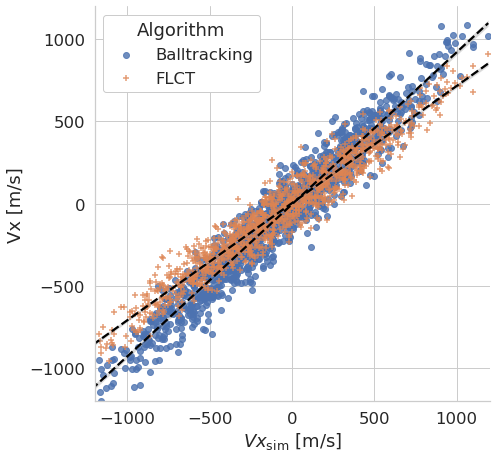

In [94]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vx_stein', y='vx', hue='Algorithm', markers=["o", "+"], line_kws={'color': 'black', 'linestyle': '--'}, height=7, legend_out=False)
g.set(xlim=[-1200, 1200], ylim=[-1200, 1200], xlabel=r'$Vx_{\mathrm{sim}}$ [m/s]', ylabel='Vx [m/s]', aspect=1)
plt.tight_layout()
plt.savefig(Path(outputdir, 'example_stein_scatter_Balltracking_FLCT.png'))
plt.savefig(Path(outputdir, 'example_stein_scatter_Balltracking_FLCT.jpg'))

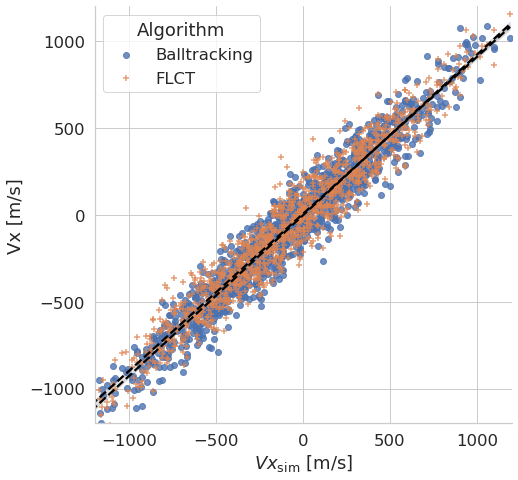

In [26]:
g = sns.lmplot(data=df1.query("nframes == 190 & FWHM==7"), x='vx_stein', y='vx_cal', hue='Algorithm', markers=["o", "+"], line_kws={'color': 'black', 'linestyle': '--'}, height=7, legend_out=False)
g.set(xlim=[-1200, 1200], ylim=[-1200, 1200], xlabel=r'$Vx_{\mathrm{sim}}$ [m/s]', ylabel='Vx [m/s]', aspect=1)
plt.tight_layout()
plt.savefig(Path(outputdir, 'example_stein_scatter_Balltracking_FLCT_calibrated.png'))
plt.savefig(Path(outputdir, 'example_stein_scatter_Balltracking_FLCT_calibrated.jpg'))

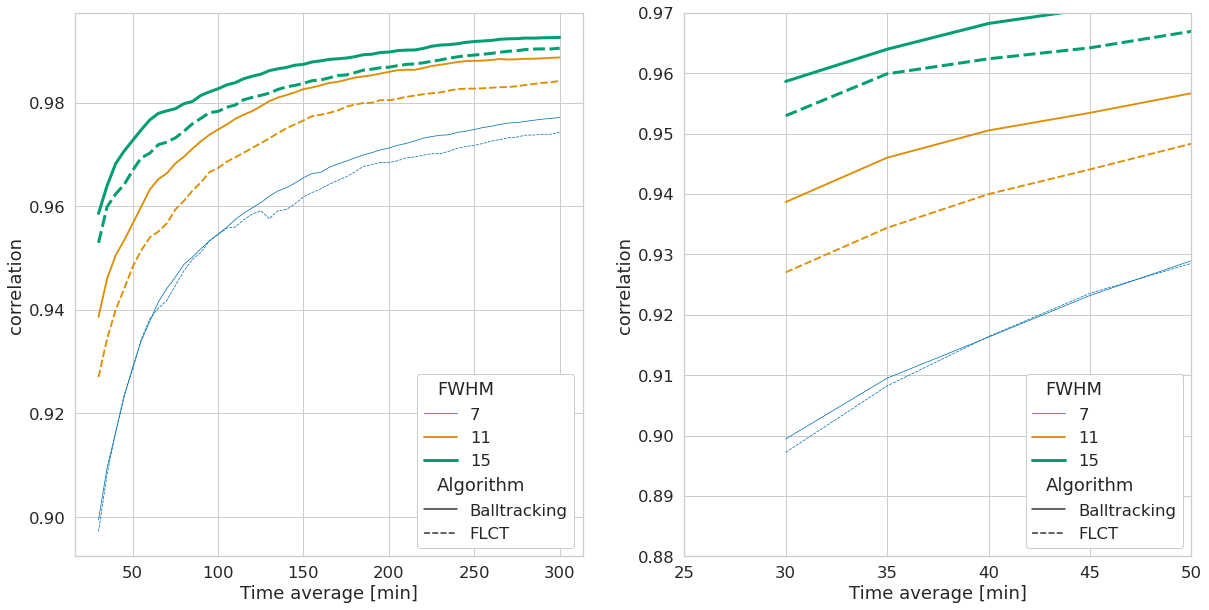

In [85]:
dfi = df2.query("kernel=='boxcar'")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
g1 = sns.lineplot(data=dfi, x='nframes', y='correlation', style='Algorithm', hue='FWHM', size='FWHM', legend='full',
            palette='colorblind', ax=axs[0])
g1.set(xlabel='Time average [min]')
# g1._legend.set_bbox_to_anchor([0.8, 0.3])

g2 = sns.lineplot(data=dfi, x='nframes', y='correlation', style='Algorithm', hue='FWHM', size='FWHM', legend='full', 
            palette='colorblind', ax=axs[1])
g2.set(xlabel='Time average [min]')
# g2._legend.set_bbox_to_anchor([0.8, 0.3])
g2.set(xlim=(25, 50))
g2.set(ylim=(0.88, 0.97))
plt.savefig(Path(outputdir, 'correlation_Balltracking_FLCT.png'))
plt.savefig(Path(outputdir, 'correlation_Balltracking_FLCT.jpg'))

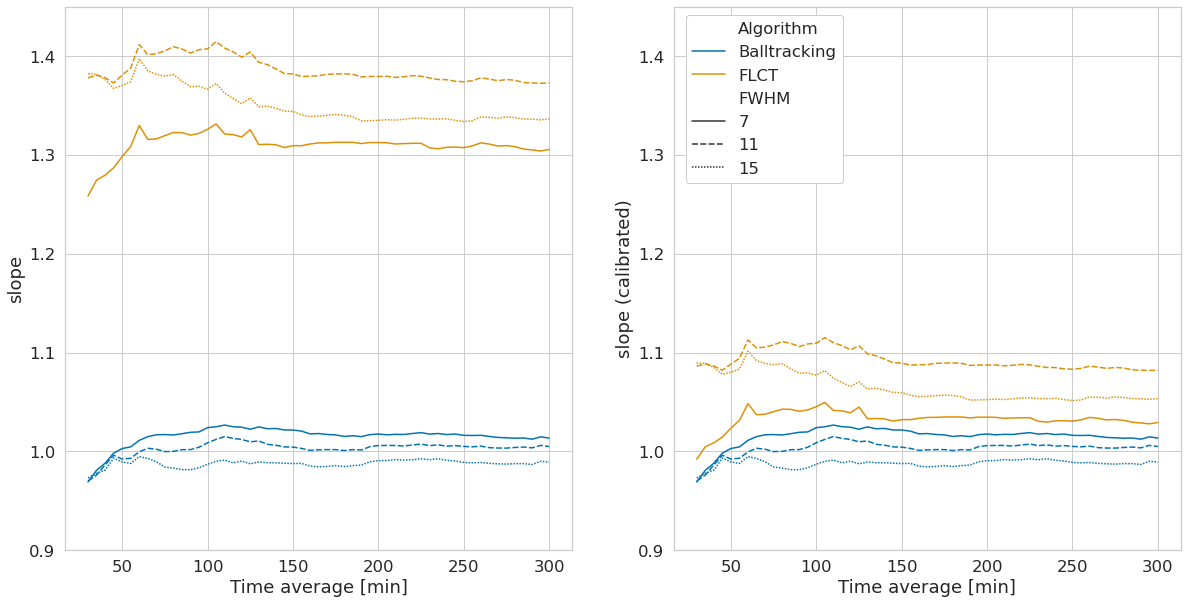

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
g1 = sns.lineplot(data=df2, x='nframes', y='slope', hue='Algorithm', style='FWHM', ax=axs[0], palette='colorblind', legend=False)
g2 = sns.lineplot(data=df2, x='nframes', y='slope_cal', hue='Algorithm', style='FWHM', ax=axs[1], palette='colorblind')
g1.set(ylim=[0.9, 1.45])
g2.set(ylim=[0.9, 1.45])
g1.set(xlabel='Time average [min]')
g2.set(xlabel='Time average [min]')
g1.set(ylabel='slope')
g2.set(ylabel='slope (calibrated)')
axs[1].legend(bbox_to_anchor= [0.35, 1], framealpha=1)
plt.savefig(Path(outputdir, 'slopes_Balltracking_FLCT.png'))
plt.savefig(Path(outputdir, 'slopes_Balltracking_FLCT.jpg'))

In [62]:
matplotlib.rcParams.update({'legend.framealpha': 1})

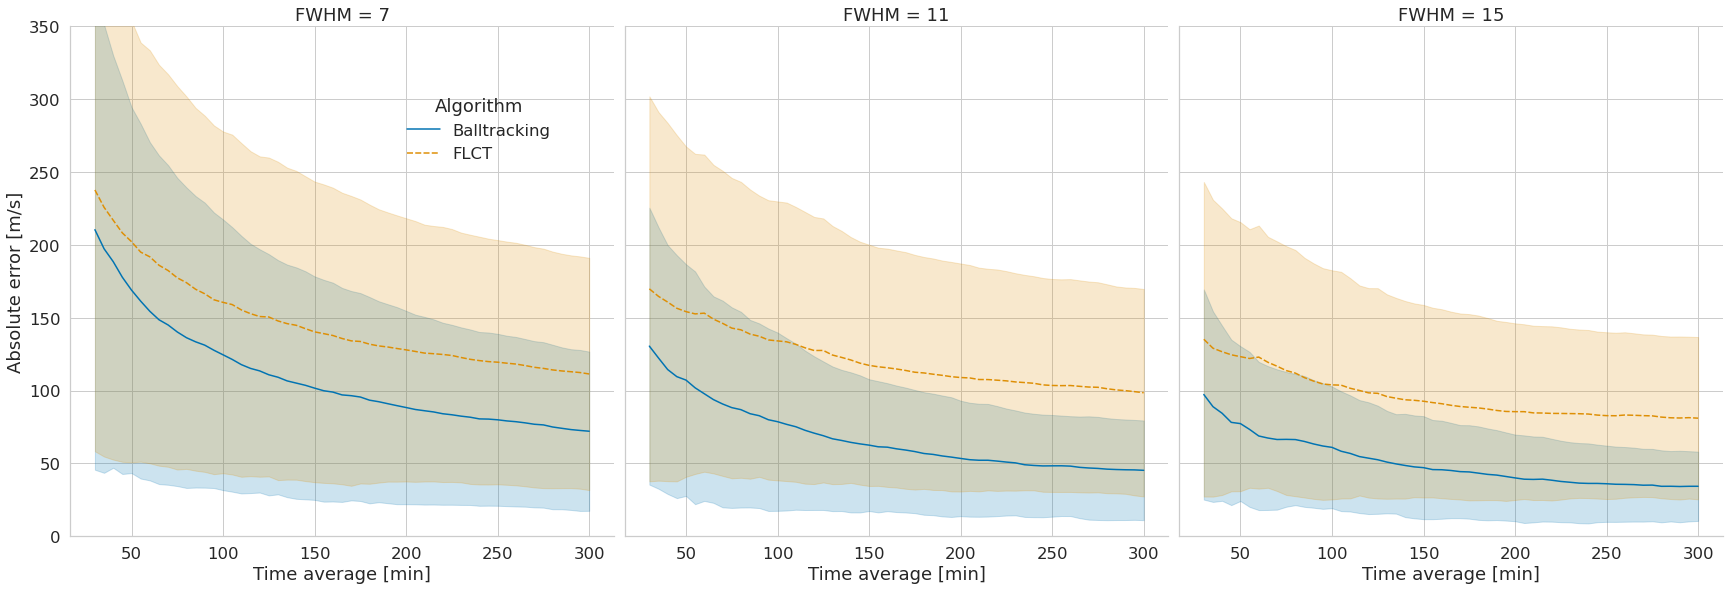

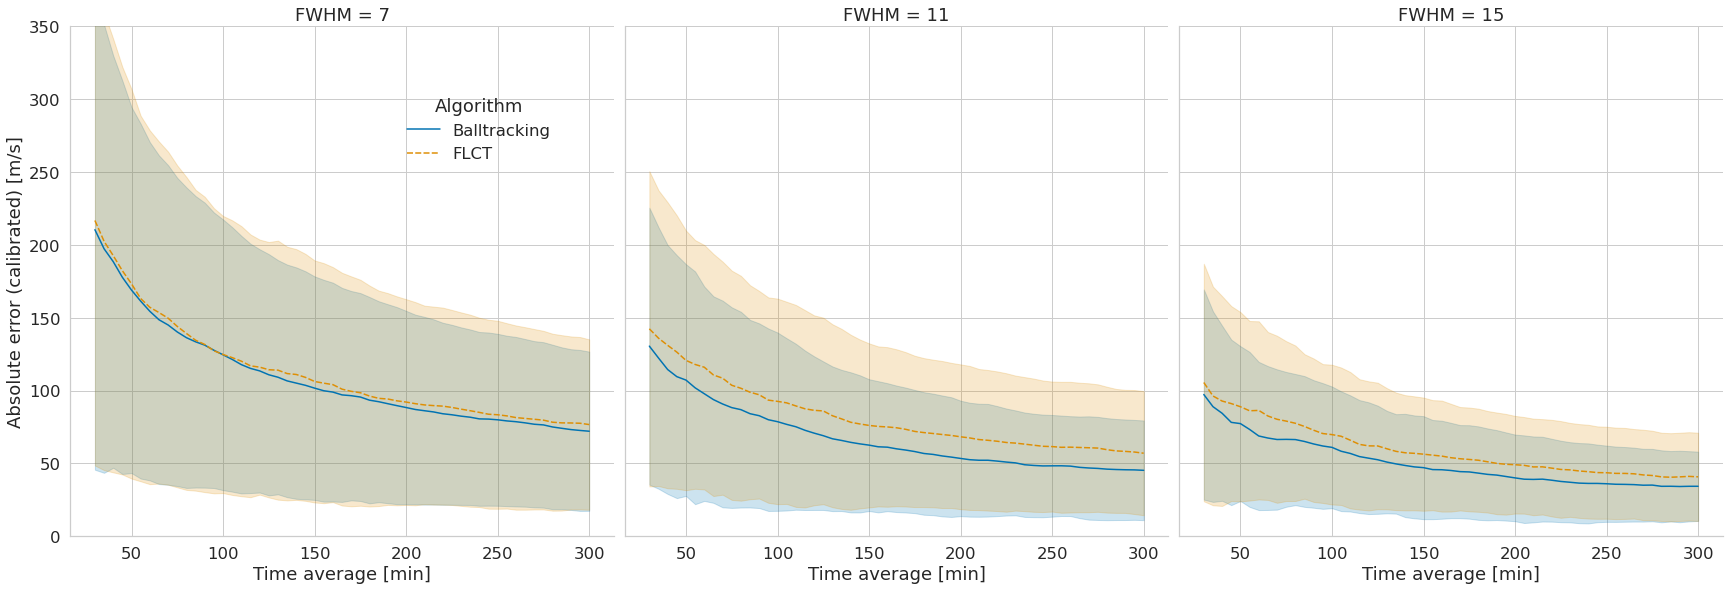

In [65]:
g1 = sns.relplot(data=df1, x='nframes', y='error',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]', ylabel='Absolute error [m/s]', ylim=[0, 350])
g1._legend.set_bbox_to_anchor([0.3, 0.8])

plt.savefig(Path(outputdir, 'Absolute_error_Balltracking_FLCT.png'))
plt.savefig(Path(outputdir, 'Absolute_error_Balltracking_FLCT.jpg'))

g1 = sns.relplot(data=df1, x='nframes', y='error_cal',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8)
g1.set(xlabel='Time average [min]', ylabel='Absolute error (calibrated) [m/s]', ylim=[0, 350])
g1._legend.set_bbox_to_anchor([0.3, 0.8])

plt.savefig(Path(outputdir, 'Absolute_error_Balltracking_FLCT_calibrated.png'))
plt.savefig(Path(outputdir, 'Absolute_error_Balltracking_FLCT_calibrated.jpg'))


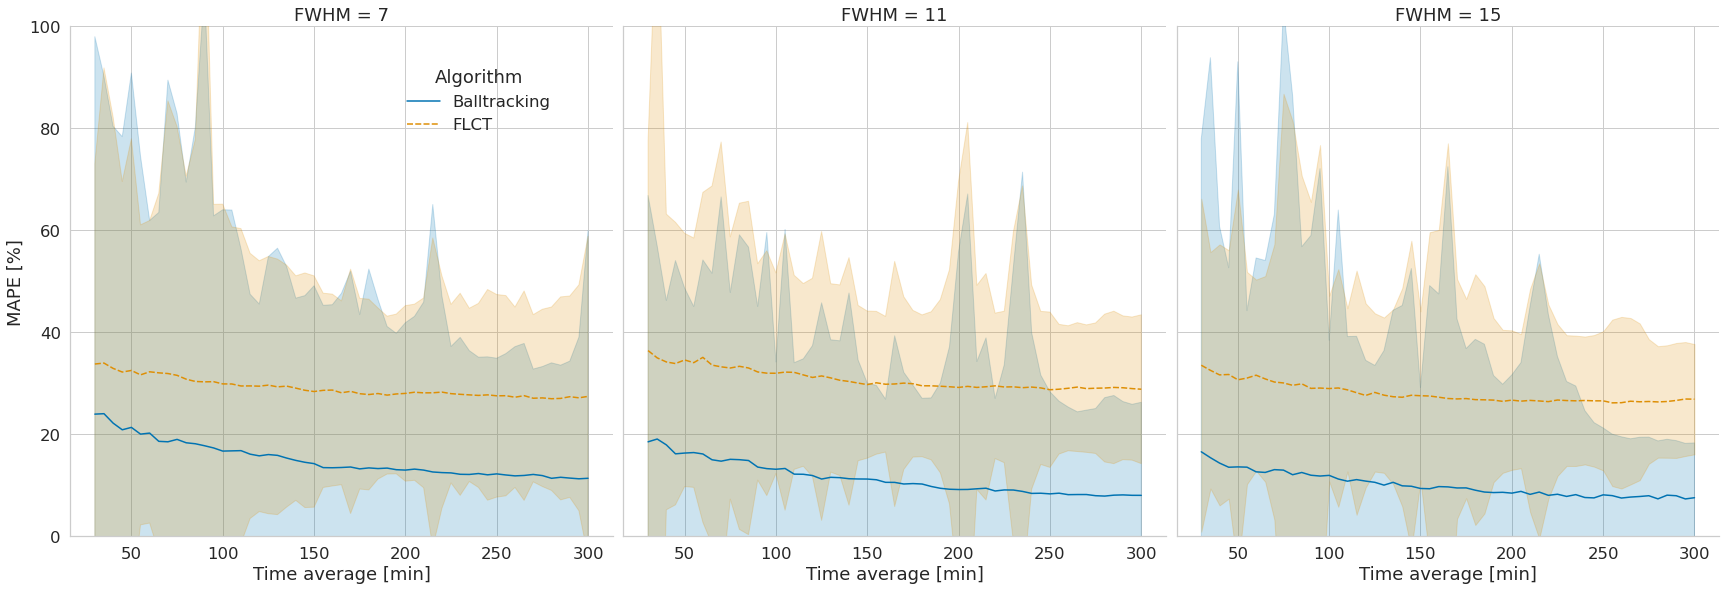

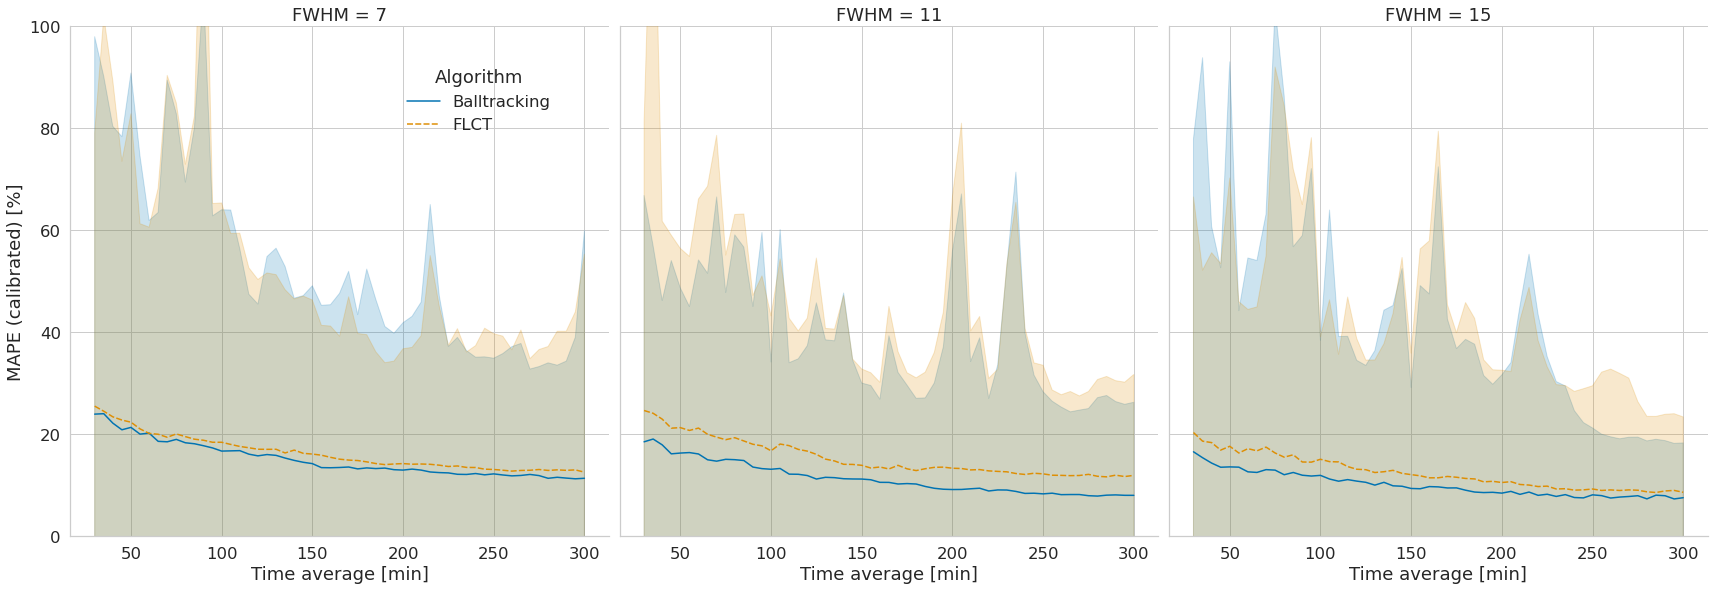

In [67]:
g1 = sns.relplot(data=df1, x='nframes', y='APE',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8, estimator=np.median)
g1.set(xlabel='Time average [min]', ylabel='MAPE [%]', ylim=[0, 100])
g1._legend.set_bbox_to_anchor([0.3, 0.85])
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_masked.png'))
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_masked.jpg'))

g1 = sns.relplot(data=df1, x='nframes', y='APE_cal',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8, estimator=np.median)
g1.set(xlabel='Time average [min]', ylabel='MAPE (calibrated) [%]', ylim=[0, 100])
g1._legend.set_bbox_to_anchor([0.3, 0.85])
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_masked_calibrated.png'))
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_masked_calibrated.jpg'))

The actual error measurement around the median are revealing that despite FLCT's calibration "a la Balltracking", the relative error is still consistently higher with more outliers than balltracking 

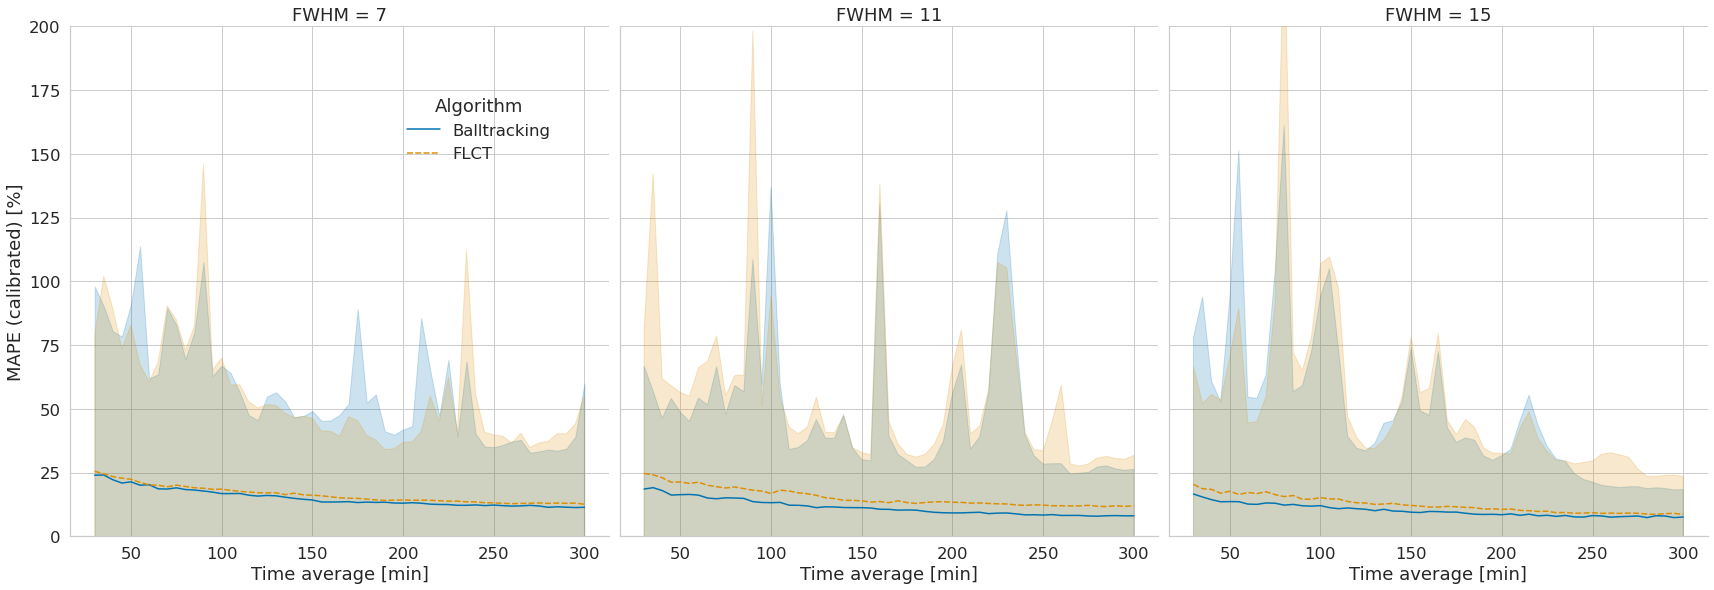

In [69]:
g1 = sns.relplot(data=df1, x='nframes', y='APE_cal_unmasked',style='Algorithm', hue='Algorithm', col='FWHM', kind='line', ci='sd', legend='full', 
            palette='colorblind', height=8, estimator=np.median)
g1.set(xlabel='Time average [min]', ylabel='MAPE (calibrated) [%]', ylim=[0, 200])
g1._legend.set_bbox_to_anchor([0.3, 0.8])
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_unmasked_calibrated.png'))
plt.savefig(Path(outputdir, 'MAPE_error_Balltracking_FLCT_unmasked_calibrated.jpg'))

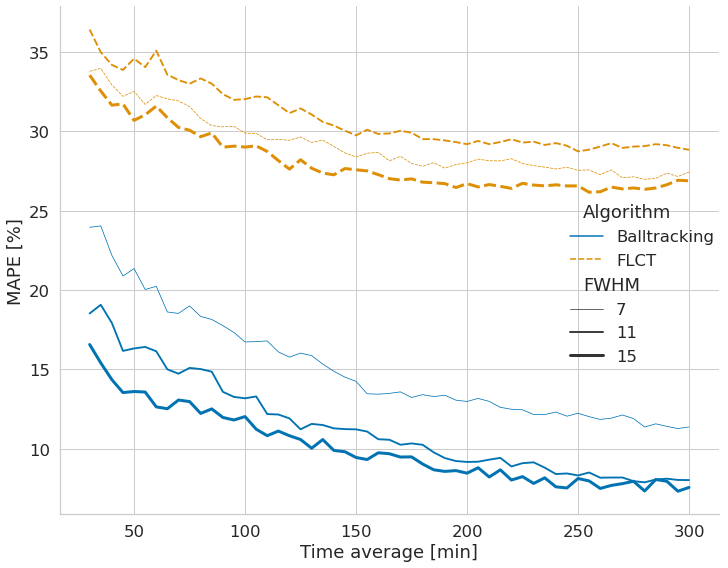

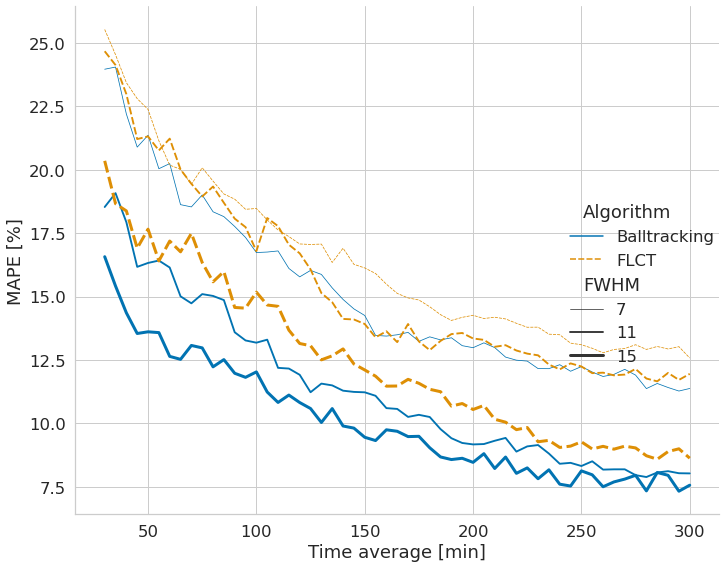

In [93]:
g3 = sns.relplot(data=df2, x='nframes', y='MAPE', style='Algorithm', size='FWHM', kind='line', legend='full', hue='Algorithm',
            palette='colorblind', height=8)
g3.set(xlabel='Time average [min]', ylabel='MAPE [%]')
plt.tight_layout()
#plt.savefig(PurePath(outputdir, 'mape.png'))
plt.savefig(Path(outputdir, 'Median_MAPE_error_Balltracking_FLCT_uncalibrated.png'))
plt.savefig(Path(outputdir, 'Median_MAPE_error_Balltracking_FLCT_uncalibrated.jpg'))

g3 = sns.relplot(data=df2, x='nframes', y='MAPE_cal', style='Algorithm', size='FWHM', kind='line', legend='full', hue='Algorithm',
            palette='colorblind', height=8)
g3.set(xlabel='Time average [min]', ylabel='MAPE [%]')
plt.tight_layout()

plt.savefig(Path(outputdir, 'Median_MAPE_error_Balltracking_FLCT_calibrated.jpg'))